In [1]:
import copy
import os
import random
from enum import Enum

import cv2 as cv
import cv2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# About the project

*This project will seek to discover if machine learning models can train on two different datasets
and still deliver acceptable results. The two datasets in question are MNIST and SVHN,
both datasets containing numbers. The MNIST dataset contains handwritten digits of a single color,
whereas SVHN contains house numbers in different shapes and colors. We will use a siamese model to see
if the model can learn features despite its differences in numerical shapes. In addition, we will
use a model with two identical networks in parallel, without weight sharing, where each network will
have it's own dataset of focus.*

# Startphase
*Before we set up the models and the training we must familiarize with the datasets used.*

## Loading the MNIST dataset
*The MNIST dataset is available through the torchvision package*

In [2]:
mnist_train_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=True)
mnist_test_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=False)


## Loading the SVHN dataset
*The SVHN dataset is also available through torchvision. However, it has a different logic for splitting into train, test and extra*

In [3]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='extra', download=True, transform=ToTensor())
svhn_test_dataset = torchvision.datasets.SVHN(root="data", split='test', download=True, transform=ToTensor())


Using downloaded and verified file: data/extra_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


## Visualizing the MNIST dataset
*As seen below, the MNIST dataset is pretty simple and contains a fairly unanimous representation*

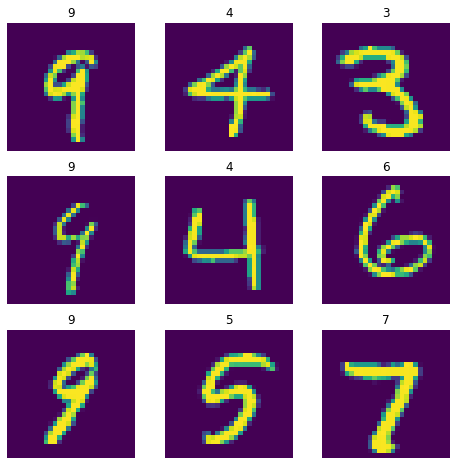

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Visualizing the SVHN dataset
*The SVHN dataset differs from the MNIST dataset in several ways. Some images are nearly impossible to interpret,
some contains several digits, and all of them are colored. To bridge the gap between these two datasets we will explore
some image processing techniques that may help us. Here we are visualising the "extra" split, as this will be used in
training due to it's clearer images.

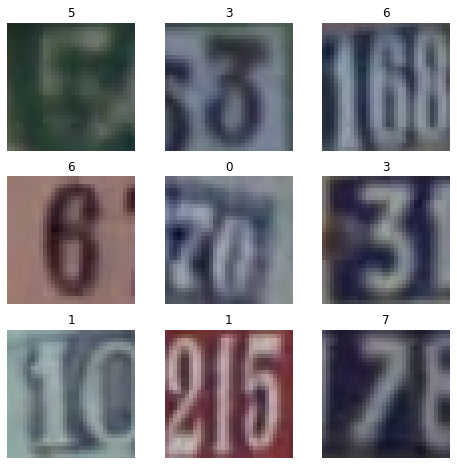

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

## Creating 2d-array with all the tensors based on label

In [6]:
num_classes = len(mnist_train_dataset.classes)

mnist_idx_by_class = [np.where(mnist_train_dataset.targets == i)[0] for i in range(0, num_classes)]
mnist_idx_test_by_class = [np.where(mnist_test_dataset.targets == i)[0] for i in range(0, num_classes)]

svhn_idx_by_class = [np.where(svhn_train_dataset.labels == i)[0] for i in range(0, num_classes)]
svhn_idx_test_by_class = [np.where(svhn_test_dataset.labels == i)[0] for i in range(0, num_classes)]

## Inspecting same label images from the two datasets
*Here we can see the difference between the datasets, compared on the same number*

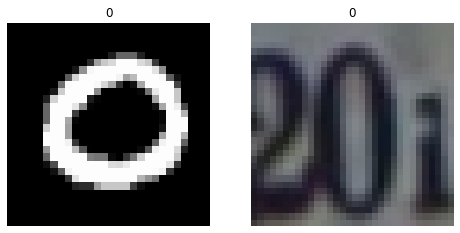

In [7]:
random_class = np.random.randint(0, num_classes)

mnist_idx = random.choice(mnist_idx_by_class[random_class])
svhn_idx = random.choice(svhn_idx_by_class[random_class])

figure = plt.figure(figsize=(8, 8))
mnist_img = mnist_train_dataset.data[mnist_idx]
svhn_img = svhn_train_dataset.data[svhn_idx]

ax = figure.add_subplot(1, 2, 1)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(svhn_img.transpose(1, 2, 0))

plt.show()



# Rewrite this based on what we end up using
## Visualizing the distribution of labels from both train splits
*As we can see the SVHN contains more images in total compared to the MNIST dataset. The distribution between the different
classes is also quite uneven. To overcome this we will reduce the amount of images per class to 6k.
The MNIST dataset generally has a quite even distribution of the digits and has a total of 60k images on the train split.
We will do no modification to this dataset*


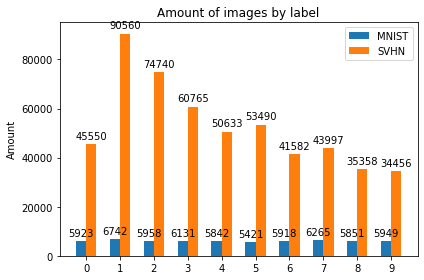

In [8]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_by_class]
len_svhn = [len(x) for x in svhn_idx_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Visualizing the distribution of labels from both test splits
*We can see that the distribution between the test splits are also quite uneven. To handle this
we will reduce the number of test images in SVHN to 1k.*

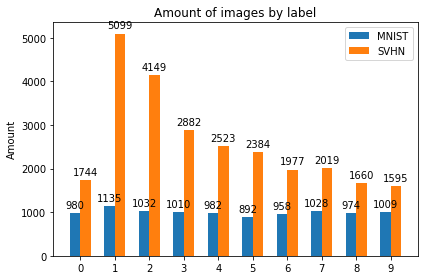

In [9]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_test_by_class]
len_svhn = [len(x) for x in svhn_idx_test_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


# Data preprocessing - Exploration phase
*As we determined above, there is quite some difference between the datasets. In this section we will
try to do some preprocessing to bridge the gap between the two*

## Grayscale
*We will start by applying grayscale as this makes the image go from 3 channel to 1 channel. This is necessary as
the MNIST images is already 1 channel.*

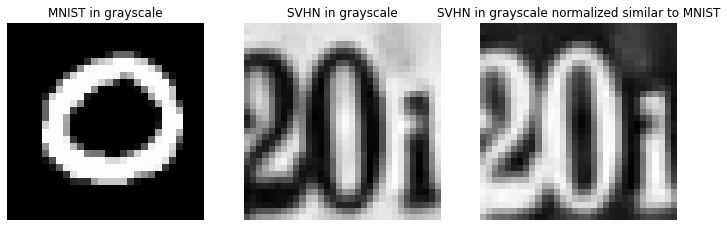

In [10]:
gray_svhn = T.Grayscale()(torch.from_numpy(svhn_img))

gray_svhn2 = gray_svhn

gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize=(12, 8))
ax = figure.add_subplot(1, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(mnist_img.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold
*Another technique we will try is thresholding the image. By doing this we will get a output image only
consisting of black and white. As we can see below, the threshold delivers some questionable results. Although
it is able to deliver only black and white, it still adds noise to the image.*

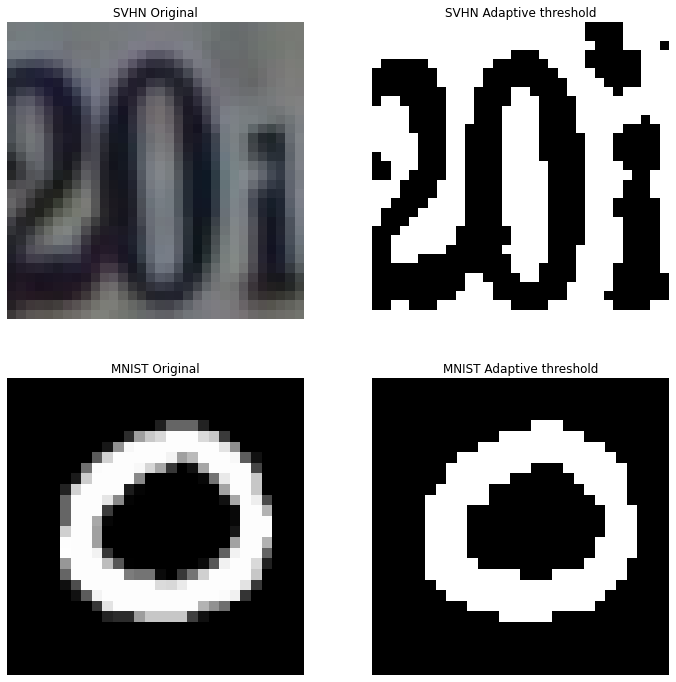

In [11]:
svhn = svhn_img.transpose(1, 2, 0)
mnist = mnist_img.detach().numpy()

svhn_grey = cv.cvtColor(svhn, cv.COLOR_BGR2GRAY)
svhn_grey = cv.normalize(svhn_grey, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svhn_grey = svhn_grey.astype(np.uint8)

#Should find a good number for reduction on adaptive threshold, e.g. the last number
svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)
#svhn_threshold = cv.bitwise_not(svhn_threshold)

#Threshold reduction number needs to be 0 on mnist
mnist = cv.normalize(mnist, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
mnist_threshold = cv.adaptiveThreshold(mnist, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(12, 12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("SVHN Original")
plt.axis("off")
plt.imshow(svhn, cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("SVHN Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold, cmap="gray")

ax = figure.add_subplot(2, 2, 3)
ax.set_title("MNIST Original")
plt.axis("off")
plt.imshow(mnist, cmap="gray")

ax = figure.add_subplot(2, 2, 4)
ax.set_title("MNIST Adaptive threshold")
plt.axis("off")
plt.imshow(mnist_threshold, cmap="gray")

plt.show()

## Equalize Hist and CLAHE
*Last we will try equalize histogram and CLAHE + grayscale. We will first convert the images into grayscale
before applying the different techniques, leaving us with a 1 channel image.*

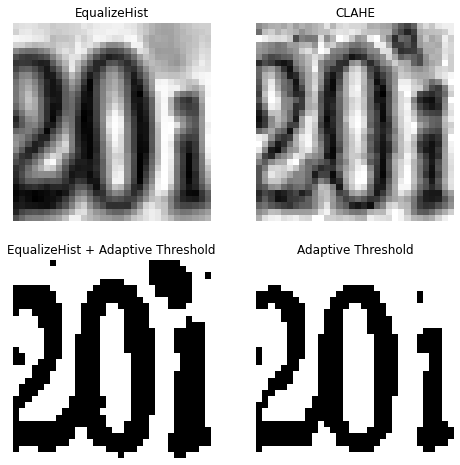

In [12]:
image = svhn

image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3., )
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 20)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("EqualizeHist + Adaptive Threshold")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")


## Clearing up variables
*Upon ending the exploration we will empty some variables to reduce the load as much as possible*


In [13]:
del svhn_idx_by_class
del svhn_train_dataset
del mnist_idx_by_class
del mnist_train_dataset

# Defining the model
*Let's start with defining the different models that will be used for the training*

### Using CUDA if possible

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Defining the loss function
*The loss function used in this project is a contrastive loss. When two images is similar, the loss will
be low and high when the images are dissimilar. The margin in the loss function sets the limit for how
the distance of dissimilar images will be. If the distance is greater than the margin, the loss is set to zero
because the representations are already far enough apart. If the distance is less than the margin,
the loss is set to the difference between the distance and the margin, encouraging the network to
push the representations farther apart.*

In [15]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)

        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + label
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        ) / 2.0
        return loss_contrastive


def threshold_contrastive_loss(output1: torch.Tensor, output2: torch.Tensor, m: float):
    """dist > m --> 1 else 0"""
    euclidean_distance = F.pairwise_distance(output1, output2)
    threshold = euclidean_distance.clone()
    threshold.data.fill_(m)
    return (euclidean_distance > threshold).float()


## Transformations
*We define the transformations that we want to use on our images*

In [ ]:
class ToNumpy:
    def __call__(self, sample):
        if len(sample.shape) == 2:
            sample = sample.unsqueeze(0)

        if isinstance(sample, torch.Tensor):
            sample = sample.numpy()
        return sample.transpose(1, 2, 0)


class Resize:
    def __call__(self, sample):
        return cv2.resize(sample, (28, 28))


class GrayScale:
    def __call__(self, sample):
        if len(sample.shape) < 3:
            return sample
        return cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)


class EqualizeHist:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.equalizeHist(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class CLAHE:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        clahe = cv.createCLAHE(clipLimit=3., )
        sample = clahe.apply(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class AdaptiveThreshold:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.adaptiveThreshold(sample, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 10)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample

        return sample


## Defining siamese network model
*Our model is based on the resnet architecture. We have slightly modified it to fit our needs of images
with only 1 channel instead of 3 channel*

In [17]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features

        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


## Non-siamese model
*Our non-siamese model is also based on the resnet18 architecture. Instead of using the same network
for both forward passes, we have two separate resnet18 networks for each input. One network will always handle input
from one dataset, and the other network will always handle the data from the remaining dataset.  We design the non-siamese
dataset such that MNIST input always will be the first and SVHN always will be second.*

In [ ]:
class NonSiameseNetwork(nn.Module):
    def __init__(self):
        super(NonSiameseNetwork, self).__init__()

        #By design of the dataset input 1 will always be mnist and input 2 will always be svhn

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features
        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.cnn2 = torchvision.models.resnet50(pretrained=False)
        self.cnn2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn2 = nn.Sequential(*(list(self.cnn2.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward_second(self, x):
        output = self.cnn2(x)
        output = output.view(output.size()[0], -1)
        output = self.fc2(output)
        return output

    def forward(self, input1, input2):
        # forward pass of mnist input
        output1 = self.forward_once(input1)
        # forward pass of svhn input
        output2 = self.forward_second(input2)
        return output1, output2


# Setting up the custom datasets


## The four possible dataset combinations

In [19]:
class DatasetType(Enum):
    MNIST = 1, #Only the MNIST dataset
    SVHN = 2, #Only the SVHN dataset
    BOTH = 3, #SVHN images will be paired with SVHN and MNIST images with MNIST
    MIX = 4 #SVHN and MNIST will be paired and mixed at random

## Siamese dataset
*The siamese dataset can be mixed based on the enum. It will preprocess the whole dataset based on
the transformation before creating the pairs. The pairs are created with both negative and positive samples,
meaning that we will have some pair of images where they are from the same class and some images
where the images are from different classes.*

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, train: bool, dataset_type: DatasetType, transform=None):
        self.dataset_type = dataset_type
        self.transform = transform
        self.train = train

        self.num_classes = 10

        if self.dataset_type != DatasetType.SVHN:
            self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
            print("Preprocessing MNIST")
            self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
            print("MNIST preprocessed")

        if self.dataset_type != DatasetType.MNIST:
            self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
            print("Preprocessing SVHN")
            self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
            print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_dataset, img1_index, img2_dataset, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index] if (img1_dataset == 0) else self.svhn_preprocessed[img1_index]
        img2 = self.mnist_preprocessed[img2_index] if (img2_dataset == 0) else self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        pairs = []

        if self.dataset_type == DatasetType.MNIST or self.dataset_type == DatasetType.BOTH:
            mnist_by_label = [np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)]

            for label in range(len(mnist_by_label)):
                for anchor_image in mnist_by_label[label]:

                    pos_image = np.random.choice(mnist_by_label[label])
                    pairs.append([0, anchor_image, 0, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(mnist_by_label[neg_label])
                    pairs.append([0, anchor_image, 0, neg_image, 1])

        if self.dataset_type == DatasetType.SVHN or self.dataset_type == DatasetType.BOTH:
            svhn_by_label = [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]
            for i in range(0, self.num_classes):
                limit = 6000 if self.train is True else 1000
                svhn_by_label[i] = svhn_by_label[i][0:limit]

            for label in range(len(svhn_by_label)):
                for anchor_image in svhn_by_label[label]:

                    pos_image = np.random.choice(svhn_by_label[label])

                    pairs.append([1, anchor_image, 1, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(svhn_by_label[neg_label])

                    pairs.append([1, anchor_image, 1, neg_image, 1])

        if self.dataset_type == DatasetType.MIX:
            datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                                 [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]
            for i in range(0, len(datasets_by_label[1])):
                limit = 6000 if self.train is True else 1000
                datasets_by_label[1][i] = datasets_by_label[1][i][0:limit]

            for dataset_index in range(len(datasets_by_label)):
                dataset_by_label = datasets_by_label[dataset_index]

                for label in range(len(dataset_by_label)):
                    for anchor_image in dataset_by_label[label]:

                        pos_dataset_index = np.random.randint(0, 2)
                        pos_image = np.random.choice(datasets_by_label[pos_dataset_index][label])

                        pairs.append([dataset_index, anchor_image, pos_dataset_index, pos_image, 0])

                        neg_dataset_index = np.random.randint(0, 2)
                        neg_label = np.random.randint(0, self.num_classes)
                        while neg_label == label:
                            neg_label = np.random.randint(0, self.num_classes)

                        neg_image = np.random.choice(datasets_by_label[neg_dataset_index][neg_label])

                        pairs.append([dataset_index, anchor_image, neg_dataset_index, neg_image, 1])

        return pairs


## Non-Siamese dataset
*The non-siamese will be preprocessed similarly to the siamese dataset. The pairs are created
in such a way that it will always be a MNIST image as the first image and a SVHN image in the second*

In [ ]:
class NonSiameseDataset(Dataset):
    def __init__(self, train: bool, transform=None):
        self.transform = transform
        self.train = train

        self.num_classes = 10

        self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
        print("Preprocessing MNIST")
        self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
        print("MNIST preprocessed")

        self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
        print("Preprocessing SVHN")
        self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
        print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_index, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index]
        img2 = self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        pairs = []
        datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                             [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]

        for i in range(0, len(datasets_by_label[1])):
            limit = 6000 if self.train is True else 1000
            datasets_by_label[1][i] = datasets_by_label[1][i][0:6000]

        for dataset_index in range(len(datasets_by_label)):
            dataset_by_label = datasets_by_label[dataset_index]

            for label in range(len(dataset_by_label)):
                for anchor_image in dataset_by_label[label]:

                    other_dataset = abs(dataset_index - 1)
                    pos_image = np.random.choice(datasets_by_label[other_dataset][label])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(datasets_by_label[other_dataset][neg_label])

                    if dataset_index == 0:
                        pairs.append([anchor_image, pos_image, 0])
                        pairs.append([anchor_image, neg_image, 1])
                    else:
                        pairs.append([pos_image, anchor_image, 0])
                        pairs.append([neg_label, anchor_image, 1])

        return pairs


## Train logic

In [ ]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()


def train(model, optimizer, criterion, dataloader, device):
    model.train()

    binary_threshold = 1.
    loss = []
    correct = 0
    total = 0.
    for img1, img2, label in dataloader:
        optimizer.zero_grad()

        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)

        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

        output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
        total += len(label)
        correct += (output_label == label).sum().item()

    loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def save_model(model, name):
    model.eval()
    # Input to the model
    example1 = torch.randn(1, 1, 28, 28)
    example2 = torch.randn(1, 1, 28, 28)
    traced_script_module = torch.jit.trace(model.cpu(), (example1, example2))
    torch.jit.save(traced_script_module, name)
    print(f"Saved model with name: {name}")


def validate(model, criterion, dataloader, device):
    model.eval()

    binary_threshold = 1.
    loss = []
    correct = 0
    total = 0.
    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)

            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
            total += len(label)
            correct += (output_label == label).sum().item()

        loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def train_pipeline(epochs, k_fold, batch_size, train_dataset, lr, device, num_workers, model):
    contrastive_loss = ContrastiveLoss()
    best_model = ""

    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler,
                                      num_workers=num_workers)
        val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler,
                                    num_workers=num_workers)

        net = model()
        net.apply(reset_weights)
        net = net.to(device)

        adam = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)

        rounds_without_improvement = 0
        best_loss = float('inf')
        best_epoch = 0

        print(f"--FOLD {fold + 1}--\n")
        for epoch in range(epochs):
            print(f"--EPOCH {epoch + 1}--")

            train_loss, train_acc = train(model=net, optimizer=adam, criterion=contrastive_loss, device=device,
                                          dataloader=train_dataloader)
            print(f"Train loss {train_loss}")
            print(f"Train acc {train_acc}")

            val_loss, val_acc = validate(model=net, criterion=contrastive_loss, device=device,
                                         dataloader=val_dataloader)
            print(f"Val loss {val_loss}")
            print(f"Val acc {val_acc}")

            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch
                best_model = copy.deepcopy(net)
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1

            if rounds_without_improvement > 3:
                break

        save_model(model=best_model,
                   name=f"fold{fold + 1}-epoch{best_epoch + 1}-transforms{random.randint(0, 10000)}.pt")

    return best_model

## Test logic

In [ ]:
def test_pipeline(test_dataset, num_workers, model, batch_size, device):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Load from disk based on the model name
    if isinstance(model, str):
        model = torch.jit.load(f"{model}.pt")
    model = model.to(device)
    res = [[], []]
    count = 1

    binary_threshold = 1.

    correct = 0
    total = 0.

    with torch.no_grad():
        for img1, img2, label in test_dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)

            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
            total += len(label)
            correct += (output_label == label).sum().item()

            for i in range(len(output1)):
                res[label[i]].append(F.pairwise_distance(output1[i], output2[i]).item())

            if count < 10:
                figure = plt.figure(figsize=(4, 4))
                figure.suptitle(f'Image no.{count}', fontsize=16)

                ax = figure.add_subplot(1, 2, 1)
                ax.set_title("Img1")
                plt.axis("off")
                plt.imshow(img1[0].cpu().squeeze(), cmap="gray")
                ax = figure.add_subplot(1, 2, 2)
                ax.set_title("Img2")
                plt.axis("off")
                plt.imshow(img2[0].cpu().squeeze(), cmap="gray")

                plt.show()

                print(f"Image no.{count}")
                if label[0].cpu() == torch.FloatTensor([[0]]):
                    caption = "Same numbers"
                else:
                    caption = "Different numbers"

                print(f"Correct label: '{caption}'")
                print(F.pairwise_distance(output1[0], output2[0]).item())
                print()

            count += 1

        print("\nImages with same number")
        print(f"Mean: {torch.mean(torch.tensor(res[0]))}")
        print(f"Std: {torch.std(torch.tensor(res[0]))}\n")

        print("Images with different number")
        print(f"Mean: {torch.mean(torch.tensor(res[1]))}")
        print(f"Std: {torch.std(torch.tensor(res[1]))}\n")

        print(f"Accuracy {correct / total}")
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        ax.boxplot(res)
        plt.show()


# Experiments

*We will conduct two main experiments, with two different preprocessing in both. In the first part,
we will use a siamese model and the siamese dataset. We will try all 4 different combinations of the dataset
with both preprocessing. In the second part we will use the non-siamese model and dataset with both preprocessings.*

In [ ]:
class Pipelines:
    def __init__(self, k_fold_splits, batch_size, lr, epochs, transform, device, num_workers, siamese: bool):
        self.k_fold = KFold(n_splits=k_fold_splits, shuffle=True)
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.transform = transform
        self.device = device
        self.num_workers = num_workers

        if siamese:
            self.dataset = SiameseDataset
            self.model = SiameseNetwork
        else:
            self.dataset = NonSiameseDataset
            self.model = NonSiameseNetwork

    def mnist_svhn_mix_pipeline(self):
        print("Starting mnist-svhn-mix pipeline")

        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MIX, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=self.device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MIX, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_svhn_pipeline(self):
        print("Starting mnist-svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.BOTH, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.BOTH, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_pipeline(self):
        print("Starting mnist pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MNIST, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MNIST, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def svhn_pipeline(self):
        print("Starting svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.SVHN, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.SVHN, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def all_pipelines(self):
        self.mnist_svhn_mix_pipeline()
        self.mnist_svhn_pipeline()
        self.mnist_pipeline()
        self.svhn_pipeline()


In [ ]:
first_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 1 pipeline")
first_config.all_pipelines()

In [ ]:
second_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 2 pipeline")
second_config.all_pipelines()

In [ ]:
third_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 3 pipeline")
third_config.mnist_svhn_mix_pipeline()

In [ ]:
forth_pipeline = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 4 pipeline")
forth_pipeline.mnist_svhn_mix_pipeline()